In [1]:
from sklearn.datasets import load_digits
import numpy as np
from sklearn.externals import joblib
from sklearn.datasets.mldata import fetch_mldata

In [2]:

#mnist = fetch_mldata('mnist-original')#, data_home='./data')

In [3]:
#mnist['data'][0]#.keys()

In [4]:
#showpic(mnist['data'][550],n=28)

In [5]:

X, y = load_digits(n_class=10,return_X_y=True)
#X=mnist["data"]
#y=mnist["target"]

In [6]:
from PIL import Image

In [7]:
def showdigit(index,multiplier=70,size=200, n = 28):
    tstimage1= Image.fromarray(X[index].reshape((n,n)) * multiplier)
    tstimage1 = tstimage1.convert('L')
    tstimage1 = tstimage1.resize((size,size))
    tstimage1.show()

In [8]:
def showpic(digit,multiplier=70,size=200, n=28):
    tstimage1= Image.fromarray(digit.reshape((n,n)) * multiplier)
    tstimage1 = tstimage1.convert('L')
    tstimage1 = tstimage1.resize((size,size))
    tstimage1.show()

In [9]:
from keras.models import Model, Sequential
from keras.layers import Flatten,Dropout, Dense, Input,merge

Using Theano backend.


In [10]:
PIC_SIZE = 64 #784
HIDDEN_VECTOR_SIZE = 3
#ENCODERENCODER
input_dist = Input(shape=(HIDDEN_VECTOR_SIZE,),name = "input_dist")
input_data = Input(shape=(PIC_SIZE,), name = "input_data")

encoder_1 = Dense(264,activation = 'sigmoid', name = "encoder_1")
encoder_2 = Dense(128,activation = 'sigmoid', name = "encoder_2")
encoder_3 = Dense(32,activation = 'sigmoid', name = "encoder_3")
encoder_4 = Dense(HIDDEN_VECTOR_SIZE,activation = 'linear', name = "encoder_4")

encoder = encoder_1(input_data)
encoder = encoder_2(encoder)
encoder = encoder_3(encoder)
encoder_out = encoder_4(encoder)

decoder_1 = Dense(128,activation = 'sigmoid',name = "decoder_1")
decoder_2 = Dense(232, activation='sigmoid',name = "decoder_2")
decoder_3 = Dense(PIC_SIZE,activation = 'linear', name = "decoder_3")

decoder = decoder_1(encoder_out)
decoder = decoder_2(decoder)
decoder_out = decoder_3(decoder)

#generator_1 = Dense(20,activation = 'relu', name = "generator_1")

#generator_out = generator_1(input_dist)


merged_vector = merge([encoder_out,input_dist], mode='sum',output_shape=(HIDDEN_VECTOR_SIZE,), name = "merge")

#predictions1 = Dense()
predictions1 = Dense(236, activation='relu')(merged_vector)
predictions2 = Dense(84, activation='relu')(predictions1)
predictions = Dense(1, activation='relu')(predictions2)

model = Model(input=[input_data,input_dist], output= [predictions,decoder_out])
#just_autoencoder = Model(input=input_data, output= decoder_out)

In [11]:
model.set_weights(joblib.load("linSIM_last_epoch.pkl"))
#1 - last

In [12]:
for i in model.layers:
    print(i.name)#[4].trainable

input_data
encoder_1
encoder_2
encoder_3
encoder_4
input_dist
merge
decoder_1
dense_1
decoder_2
dense_2
decoder_3
dense_3


In [13]:
def tester_error(y_true,y_pred):
    y_pred = np.array(y_pred)
    #log(pred) if true = 0
    #log(1-pred) if true=1
    return np.log(y_true - y_pred*((-1)**(y_true+1))).sum()

def generator_error(y_true,y_pred):
    #y_pred = np.array(y_pred)
    return np.log(np.ones(y_pred.shape)-y_pred).sum()

def generate_input(length=64,bottom_border =0 ,top_border=1):
    '''
    generates list of length length with trash from custom distribution.
    '''
    return 0

In [14]:
from theano.tensor import basic as tensor, subtensor

def generator_error_theano(y_true,y_pred):
    '''
    TODO write normalisation
    '''
    return -tensor.log(1.0 - y_pred)  #-(target * tensor.log(output) + (1.0 - target) *
    #return -tensor.log(1.0 + (y_pred-1.0))
    
def tester_error_theano(target,output):
    '''
    y_true = 0 -> it was real
    '''
    
    return -((target) * tensor.log(output) + (1.0 - target) * tensor.log(1.0 - output))

def Nobody_Cares(y_true,y_pred):
    return y_pred*0.0

In [17]:
npx = np.array(X)
bottom = np.array(X).min()
top = np.array(X).max()
X = X/top

In [18]:
top

1.0

In [19]:
generator_layers = 1
tester_train_steps = 1
n_epoch = 500
xnum=0

In [20]:
from keras.optimizers import SGD

opt = "adam"#SGD(lr = 0.001)

In [21]:
#just_autoencoder.compile("adam", loss = "mse")

In [22]:
#just_autoencoder.fit(X,X,nb_epoch = 400 , verbose = 0)

In [23]:
#showpic(just_autoencoder.predict(X[0].reshape(-1,PIC_SIZE)),n=8,multiplier = 50)
#showpic(X[0],n=8)

In [24]:
X.shape

(1797, 64)

In [25]:
num_encoder_train = 1

In [26]:
from tqdm import tqdm

In [27]:
model.layers[-1].trainable = False
model.compile(opt, loss = [generator_error_theano,Nobody_Cares])

In [28]:
#batch_rep = np.repeat(np.zeros((20,)).reshape((-1,20)),2,axis=0)
#batch_rep2 = np.repeat(np.array(X[np.random.choice(len(X))]).reshape((-1,784)), 2 , axis=0)
#bbatch = X[np.random.choice(len(X),2)]

In [29]:
#model.train_on_batch([bbatch,batch_rep],[np.array([1.0,1.0]),np.vstack([nobody_cares_decoder,nobody_cares_decoder])])

In [30]:
#model.set_weights(joblib.load("modelPROPER_11_epoch.pkl"))

In [31]:
from sklearn.datasets import make_swiss_roll

In [32]:
dist = make_swiss_roll

Updates: autoencoder -> guesser -> generator

In [33]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu")


nobody_cares = np.array([0.0])
nobody_cares_decoder = np.zeros((PIC_SIZE,)).reshape((-1,PIC_SIZE))
for epoch in range(0,n_epoch):
    
    joblib.dump(model.get_weights(),"linSIM_last_epoch.pkl",compress=9)
    
    print("Epoch ",epoch)#,"Iter ",xnum)
    for xnum in tqdm(range(0,len(X))):
        #unfreezing encoder
        #for i in model.layers:
        #    if "encoder" or "decoder" in i.name:
        #        i.trainable = True
        #freezing generator
        #for i in model.layers:
        #    if "generator" in i.name:
        #        i.trainable = False
        
        #freezing tester
        #model.layers[-1].trainable = False
        
        #model.compile(opt , loss = [Nobody_Cares,"mse"])
        
        #for i in range(num_encoder_train):
         #   #first data then dist
          #  model.train_on_batch([np.array(X[xnum]).reshape((-1,PIC_SIZE)),np.zeros((HIDDEN_VECTOR_SIZE,)).reshape((-1,HIDDEN_VECTOR_SIZE))],[nobody_cares,np.array(X[xnum]).reshape((-1,PIC_SIZE))])
        
        #unfreezing tester
        model.layers[-1].trainable = True
        
        #freezing encoder
        for i in model.layers:
            if "encoder" or "decoder" in i.name:
                i.trainable = False
                
        model.compile(opt , loss = [tester_error_theano,Nobody_Cares])
        #doing tester_train_steps of tester training
        for k in range(0,tester_train_steps):
            #for xnum in range(0,len(X)):
            model.train_on_batch([np.array(X[xnum]).reshape((-1,PIC_SIZE)),np.zeros((HIDDEN_VECTOR_SIZE,)).reshape((-1,HIDDEN_VECTOR_SIZE))],[np.array([0.0]),nobody_cares_decoder]) #inputs original image
            model.train_on_batch([np.zeros((PIC_SIZE,)).reshape((-1,PIC_SIZE)),dist(HIDDEN_VECTOR_SIZE)[1].reshape((-1,HIDDEN_VECTOR_SIZE))],[np.array([1.0]),nobody_cares_decoder]) #inputs noise to generator
            

        #Unfreezing generator        
        #for i in model.layers:
        #    if "generator" in i.name:
        #        i.trainable = True
        
        #unfreezing encoder
        for i in model.layers:
            if "encoder" or "decoder" in i.name:
                i.trainable = True
                
        #freezing tester
        model.layers[-1].trainable = False
        model.compile(opt, loss = [generator_error_theano,"mse"])
        #doing ? steps of generator training
        for nn in range(0,3):
            #model.train_on_batch([np.zeros((784,)).reshape((-1,784)),np.random.uniform(bottom,top,784).reshape((-1,784))],[np.array([1.0]),nobody_cares_decoder]) #inputs noise to generator
            sampl = X[np.random.choice(len(X))]
            model.train_on_batch([np.array(sampl).reshape((-1,PIC_SIZE)),np.zeros((HIDDEN_VECTOR_SIZE,)).reshape((-1,HIDDEN_VECTOR_SIZE))],[np.array([1.0]),np.array(sampl).reshape((-1,PIC_SIZE))]) #inputs real to autoenc-generator

Using gpu device 0: GeForce GTX 860M (CNMeM is disabled, cuDNN 4007)
  0%|          | 0/1797 [00:00<?, ?it/s]

Epoch  0


  0%|          | 0/1797 [00:00<?, ?it/s]

Epoch  1


  0%|          | 0/1797 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/1797 [00:00<?, ?it/s]

Epoch  3


  0%|          | 0/1797 [00:00<?, ?it/s]

Epoch  4


  0%|          | 0/1797 [00:00<?, ?it/s]

Epoch  5


 32%|███▏      | 584/1797 [32:57<1:10:33,  3.49s/it]


KeyboardInterrupt: 

In [ ]:
dist(HIDDEN_VECTOR_SIZE,random_state=331)[1]

In [34]:
for i in range(len(model.layers)):
            if ("encoder" in model.layers[i].name):
                last_enc = i

In [35]:
last_enc

4

In [36]:
model.layers[0].name

'input_data'

In [37]:
import theano
get_activations = theano.function([model.layers[0].input], model.layers[last_enc].output, allow_input_downcast=True)

In [38]:
def get_hiddens(X):
    hiddens=[]
    for i in X:
        #hiddens.append(model.predict([np.array(i).reshape((-1,PIC_SIZE)),np.zeros((HIDDEN_VECTOR_SIZE,)).reshape((-1,HIDDEN_VECTOR_SIZE))])[1][0])#,[np.array([1.0]),nobody_cares_decoder])
        hiddens.append(get_activations(np.array(i).reshape((-1,PIC_SIZE)))[0])
    return hiddens#pred,ppred = model.predict([np.random.uniform(bottom,top,HIDDEN_VECTOR_SIZE).reshape((-1,HIDDEN_VECTOR_SIZE)),np.zeros((PIC_SIZE,)).reshape((-1,PIC_SIZE))])

In [39]:
X_hiddens.shape

NameError: name 'X_hiddens' is not defined

In [40]:
from sklearn.manifold import TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


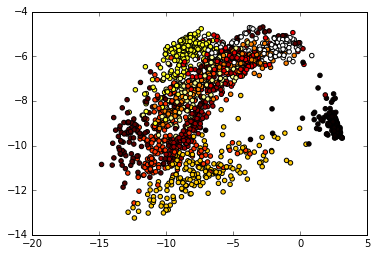

In [41]:
X_hiddens = np.array(get_hiddens(X))
#X_tsne = TSNE(n_components=2, n_iter=200).fit_transform(X_hiddens)
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(set(y))))
#colors_to_use = []
#for label in y:
#    colors_to_use.append(colors[label])

pylab.scatter(X_hiddens[:, 0], X_hiddens[:, 2], c=y, cmap=pylab.cm.hot)#,colors_to_use)#
#pylab.xlim([0.03+1.409e1,0.037+1.409e1])
#pylab.ylim([-3.481,-3.479])

In [58]:
X_hidden = np.array(X_hiddens)

In [63]:
X_hidden = (X_hiddens - 0.999)*1000.0

In [42]:
import seaborn as sns
sns.plt.plot(X_hiddens[:, 0], X_hiddens[:, 2], ".")
sns.plt.show()

In [85]:
np.random.standard_exponential(HIDDEN_VECTOR_SIZE)


array([ 1.04877342,  1.03187521,  0.15028631,  2.05943032,  1.19115   ,
        0.03604689])

In [88]:
from sklearn.datasets import make_swiss_roll
#sklearn.datasets.make_swiss_roll

NameError: name 'sklearn' is not defined

In [125]:
dots = make_swiss_roll(n_samples = 1000 , random_state = 123)[0]
dots_x = dots[:, [0,2]]
#dots_y = dots[:, 2]
print(dots_x)
#dots = TSNE(n_components=2, n_iter=200).fit_transform(dots)
#pylab.scatter(dots_x, dots_y)#, c=y, cmap=pylab.cm.hot)

[[  3.12587105 -10.83454657]
 [  3.18795895   6.68827291]
 [  5.77759401   3.68070284]
 ..., 
 [ -1.03646007   7.91660391]
 [  0.18663146  -4.74800949]
 [  2.65508277   7.00544048]]


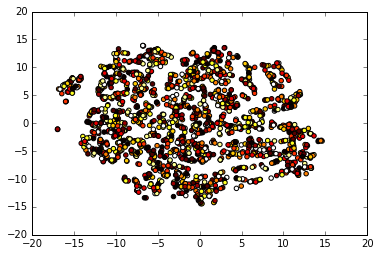

In [86]:
random_hiddens = [np.random.standard_exponential(size = HIDDEN_VECTOR_SIZE) for i in range(len(y))]#= get_hiddens(X)
X_tsne = TSNE(n_components=2, n_iter=200).fit_transform(random_hiddens)
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(set(y))))
#colors_to_use = []
#for label in y:
#    colors_to_use.append(colors[label])

pylab.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=pylab.cm.hot)#,colors_to_use)#

In [146]:

pred2 = model.predict([np.zeros((64,)).reshape((-1,64)),np.array(X[44]).reshape((-1,64))])

In [147]:
pred2

array([[ 0.024002]], dtype=float32)

In [122]:
import theano
get_activations = theano.function([model.layers[0].input], model.layers[1].output, allow_input_downcast=True)
#activations = get_activations(X_batch) # same result as above

In [150]:
tst = dist(64).reshape((-1,64))
showpic(tst,size=500,multiplier = 20)
Generated = get_activations(tst)
showpic(Generated,size=500,multiplier = 20)
showdigit(np.random.randint(low=0,high=120),size=500,multiplier = 20)

In [151]:
joblib.dump(model,"Sigmoid500epoch3gen.pkl",compress=9)

['Sigmoid500epoch3gen.pkl']

In [249]:
PIC_SIZE = 64 #784
HIDDEN_VECTOR_SIZE = 3
#ENCODERENCODER
#input_dist = Input(shape=(HIDDEN_VECTOR_SIZE,),name = "input_dist")
input_data = Input(shape=(PIC_SIZE,), name = "input_data")

encoder_1 = Dense(264,activation = 'sigmoid', name = "encoder_1")
encoder_2 = Dense(128,activation = 'sigmoid', name = "encoder_2")
encoder_3 = Dense(32,activation = 'sigmoid', name = "encoder_3")
encoder_4 = Dense(HIDDEN_VECTOR_SIZE,activation = 'sigmoid', name = "encoder_4")

encoder = encoder_1(input_data)
encoder = encoder_2(encoder)
encoder = encoder_3(encoder)
encoder_out = encoder_4(encoder)

decoder_1 = Dense(128,activation = 'sigmoid',name = "decoder_1")
decoder_2 = Dense(232,activation = 'sigmoid',name = "decoder_2")
decoder_3 = Dense(PIC_SIZE,activation = 'sigmoid', name = "decoder_3")

decoder = decoder_1(encoder_out)
decoder = decoder_2(decoder)
decoder_out = decoder_3(decoder)

#generator_1 = Dense(20,activation = 'relu', name = "generator_1")

#generator_out = generator_1(input_dist)


#merged_vector = merge([encoder_out,input_dist], mode='sum',output_shape=(HIDDEN_VECTOR_SIZE,), name = "merge")

#predictions1 = Dense()
#predictions = Dense(1, activation='relu')(merged_vector)

#model = Model(input=[input_data,input_dist], output= [predictions,decoder_out])
just_autoencoder = Model(input=input_data, output= decoder_out)